In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import datasets
import cv2

In [ ]:
# linalg
# import sys
# !{sys.executable} -m pip install opencv-python

In [53]:
def read_images(folder):
    images_path = os.listdir(folder)
    
    expres_code = ['NE','HA','AN','DI','FE','SA','SU']
    expressions = [ 0,   1,   2,   3,   4,   5,   6]

    img_data_list = []
    labels = []

    for i, p in enumerate(images_path):
        images_path[i] = os.path.join(folder, p)
        label = p[3:5]

        img = cv2.imread(images_path[i], cv2.IMREAD_GRAYSCALE)

        width = 64
        height = 64
        dim = (width, height)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

        img_data_list.append(resized)
        
        labels.append(expres_code.index(label))

    img_data = np.array(img_data_list)
    return img_data , labels

In [54]:
# folder = 'jaffe/'
folder = '/content/sample_data/jaffe'

img_data , labels = read_images(folder)    
print(labels)
print(len(img_data), img_data[0].shape)

[4, 2, 0, 6, 1, 1, 6, 0, 2, 3, 5, 6, 4, 5, 2, 0, 0, 5, 0, 4, 1, 4, 6, 3, 0, 4, 0, 6, 2, 0, 4, 0, 4, 6, 0, 1, 4, 1, 0, 4, 3, 6, 2, 0, 2, 0, 5, 1, 4, 2, 2, 5, 3, 6, 0, 6, 5, 1, 2, 1, 2, 5, 3, 1, 5, 2, 3, 5, 3, 4, 1, 1, 6, 0, 6, 2, 4, 1, 2, 3, 2, 2, 6, 5, 0, 4, 1, 3, 1, 6, 0, 4, 4, 1, 3, 0, 4, 0, 3, 0, 6, 5, 4, 0, 1, 1, 0, 2, 3, 1, 5, 6, 5, 3, 4, 5, 4, 3, 3, 5, 4, 6, 3, 5, 5, 2, 3, 3, 2, 6, 3, 5, 4, 5, 1, 2, 4, 3, 6, 4, 1, 5, 0, 3, 6, 3, 6, 5, 5, 6, 6, 6, 1, 4, 5, 1, 2, 1, 2, 0, 5, 2, 2, 1, 6, 2, 3, 4, 5, 1]
170 (64, 64)


Text(0.5, 0.98, '16th faces from dataset')

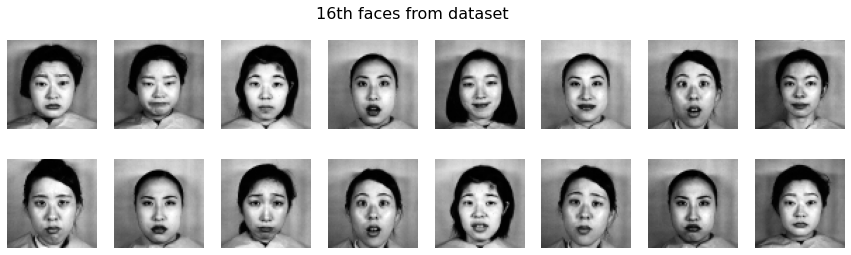

In [62]:
fig = plt.figure(figsize=(15,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(img_data[i] , cmap='gray')
    plt.axis('off')
plt.suptitle('16th faces from dataset', size = 16)

In [60]:
#flatten images
def flaten(img_data):
    flat_imgs = np.zeros((len(img_data), 64*64))
    for i in range(len(img_data)):
        flat_imgs[i] = img_data[i].reshape(1,-1)
    return flat_imgs

def zero_mean(dataset):
    mean = np.mean(dataset,axis=0)
    return dataset - mean , mean

In [139]:
flat_imgs = flaten(img_data)
# print(flat_imgs)
zero_mean_data, mean_data = zero_mean(flat_imgs)
# print(mean_data)
# zero_mean_data

In [141]:
from numpy import random
# import random
import copy
from pylab import imshow, show, get_cmap

# img_data -> 170 images with size 64*64

# one way of implementing outliers is to change labels of images randomly
def add_outlier(img_list, labels, outlier_percentage, outlier_method='nonsense-image'):
    num_of_outliers = int(outlier_percentage*len(img_data)/100)
    
    new_labels = copy.deepcopy(labels)
    new_img_list = list(copy.deepcopy(img_list))
    
    if outlier_method=='nonsense-image':
        for i in range(num_of_outliers):
            new_im = random.random((64,64))      # create a new non-sense image
            new_im_label = random.randint(0, 7)  # we have 7 class labels
            
            new_img_list.append(new_im)
            new_labels.append(new_im_label)

    elif outlier_method=='label-changing':
        for i in range(num_of_outliers):
            random_img_index = random.randint(0,img_list.shape[0])
            remained_labels = [0, 1, 2, 3, 4, 5, 6]
            remained_labels.remove(labels[random_img_index])
            random_label_index = remained_labels[random.randint(0,6)]
            new_labels[random_img_index] = random_label_index
    
    elif outlier_method=='hybrid':
        for i in range(num_of_outliers):
            r = random.randint(0, 2)
            if r==0:
                # create nonsense image
                new_im = np.random.random((64,64))      # create a new non-sense image
                new_im_label = random.randint(0, 7)     # we have 7 class labels
                new_img_list.append(new_im)
                new_labels = np.append(new_labels, new_im_label)

            else:
                # change one of labels
                random_img_index = random.randint(0,img_list.shape[0])
                remained_labels = [0, 1, 2, 3, 4, 5, 6]
                remained_labels.remove(labels[random_img_index])
                random_label_index = remained_labels[random.randint(0,6)]
                new_labels[random_img_index] = random_label_index

    return np.array(new_img_list), new_labels

In [154]:
class FLDA:
    def __init__(self):
        self.n_components = None
        self.all_eigenvectors = None

    def fit(self, X, y, epsilon=0.00018845):
        # X must be actuall images 
        
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        self.mean = mean_overall

        self.SW = np.zeros((n_features, n_features))
        self.SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # (n_feature, n_c) * (n_c, n_feature) = (n_feature, n_feature)
            self.SW += (X_c - mean_c).T.dot((X_c - mean_c))

            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            self.SB += n_c * (mean_diff).dot(mean_diff.T)


        self.sing_SW = self.SW + epsilon* np.eye(self.SW.shape[0],self.SW.shape[1])
        self.result = np.linalg.inv(self.sing_SW).dot(self.SB)
        
        
        eigenvalues, eigenvectors = np.linalg.eig(self.result)
        eigenvectors = eigenvectors.T                    # for sorting eigenvectors we transpose it
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.all_eigenvectors = eigenvectors


    def get_n_components(self, n_components):
        self.n_components = n_components
        return self.all_eigenvectors[0 : self.n_components]

    def project(self, X):
        # X must be actuall images 
        return np.dot(X, self.all_eigenvectors[0: self.n_components].T)     # compo.T because we save transpose of eigenvectors 

    def reconsturct(self, X_projected, add_mean=False):
        if add_mean==True:
            return X_projected @ self.all_eigenvectors[0: self.n_components] + self.mean
        else:
            return X_projected @ self.all_eigenvectors[0: self.n_components] 

In [238]:
from sklearn.metrics import mean_squared_error
import math

def MSE_element_wise(x_original, x_reconstruct):
  # mse = (np.square(x_original.real - x_reconstruct.real)).mean(axis=None)
  mse = mean_squared_error(x_original, x_reconstruct.real)
  return mse

In [167]:
def plot_recontruct(X_reconstruct, X, k):

    fig2 = plt.figure(figsize=(15,4))
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow(X[i].reshape(64,64) , cmap='gray')
        plt.axis('off')
    plt.suptitle('Main images ', size = 8)

    fig = plt.figure(figsize=(15,4))
    for i in range(8):
        plt.subplot(2,8,i+1)
        plt.imshow(X_reconstruct.real[i].reshape(64, 64) , cmap='gray')
        plt.axis('off')
    text = 'Reconstructed by '+ str(k)
    plt.suptitle(text, size = 8)


In [223]:
# K basis vectors    K = 6

X = flat_imgs
y = labels
print("Shape of X:", X.shape)

n_components = 6

lda = FLDA()
lda.fit(X, y)
W = lda.get_n_components(n_components)
print("Shape of W:", W.shape)

X_projected = lda.project(X)
print("Shape of projected X:", X_projected.shape)

X_reconstruct = lda.reconsturct(X_projected)
print("Shape of reconstructed X:", X_reconstruct.shape)


Shape of X: (170, 4096)
Shape of W: (6, 4096)
Shape of projected X: (170, 6)
Shape of reconstructed X: (170, 4096)


Checking for singulaity of implemented SW

In [156]:
np.linalg.matrix_rank(lda.sing_SW)

4096

In [158]:
print(np.allclose(np.linalg.inv(lda.sing_SW)@lda.sing_SW, np.eye(lda.sing_SW.shape[0]), atol=1e-2))


True


Text(0.5, 0.98, 'fisher faces')

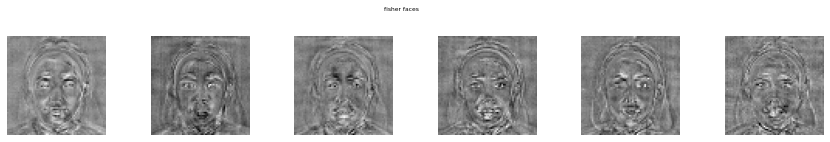

In [166]:
fig = plt.figure(figsize=(15,4))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(W.real[i].reshape(64, 64) , cmap='gray')
    plt.axis('off')
plt.suptitle('fisher faces', size = 6)

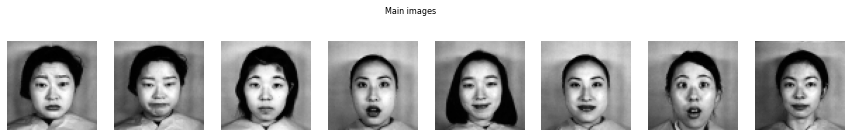

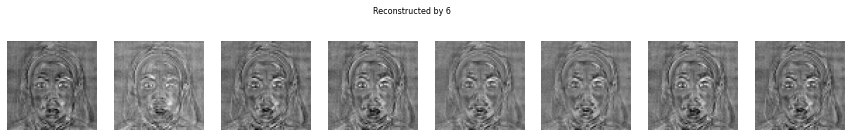

In [168]:
plot_recontruct(X_reconstruct, X, 6) 

In [239]:
mse_k_6 = MSE_element_wise(X, X_reconstruct)
mse_k_6

16092.15570203752

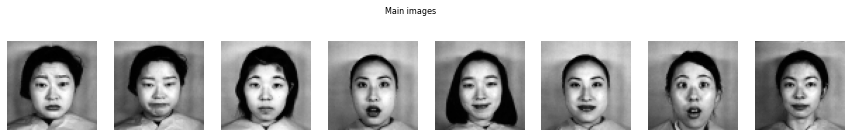

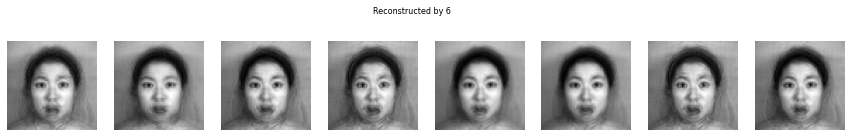

In [233]:
# Reconstruct with Adding mean face
X_reconstruct_addMean = lda.reconsturct(X_projected, add_mean=True)
plot_recontruct(X_reconstruct_addMean, X, 6) 

In [240]:
mse_k_6_addMean = MSE_element_wise(X, X_reconstruct_addMean)
mse_k_6_addMean

1409.5893691328283

In [241]:
# K basis vectors    K = 1

X = flat_imgs
y = labels
print("Shape of X:", X.shape)

n_components = 1

lda = FLDA()
lda.fit(X, y)
W = lda.get_n_components(n_components)
print("Shape of W:", W.shape)

X_projected = lda.project(X)
print("Shape of projected X:", X_projected.shape)

X_reconstruct = lda.reconsturct(X_projected)
print("Shape of reconstructed X:", X_reconstruct.shape)


Shape of X: (170, 4096)
Shape of W: (1, 4096)
Shape of projected X: (170, 1)
Shape of reconstructed X: (170, 4096)


Text(0.5, 0.98, 'fisher faces')

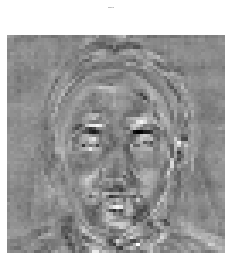

In [172]:
plt.imshow(W.real[0].reshape(64, 64) , cmap='gray')
plt.axis('off')
plt.suptitle('fisher faces', size = 1)

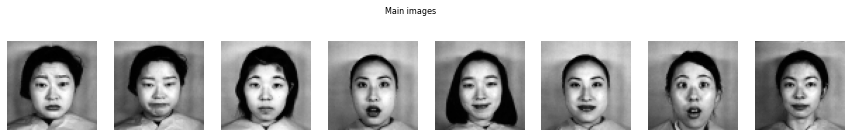

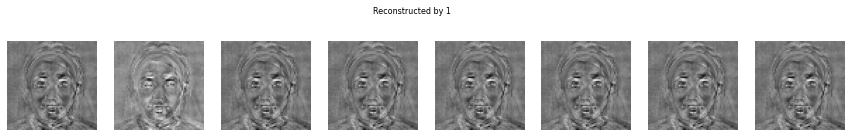

In [242]:
plot_recontruct(X_reconstruct, X, 1) 

In [243]:
mse_k_1 = MSE_element_wise(X, X_reconstruct)
mse_k_1

16131.522712628377

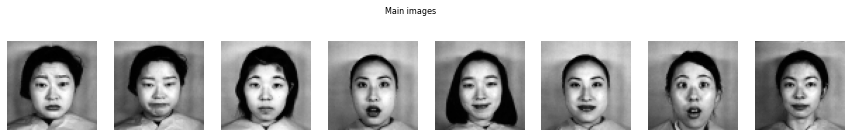

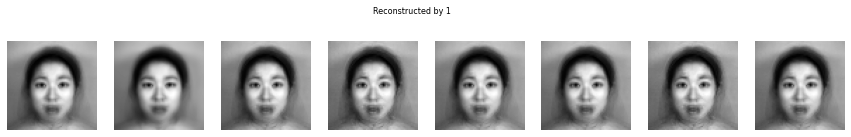

In [244]:
# Reconstruct with Adding mean face
X_reconstruct_addMean = lda.reconsturct(X_projected, add_mean=True)
plot_recontruct(X_reconstruct_addMean, X, 1) 

In [245]:
mse_k_1_addMean = MSE_element_wise(X, X_reconstruct_addMean)
mse_k_1_addMean

1384.8408980476254

In [246]:
# K basis vectors    K = 29

X = flat_imgs
y = labels
print("Shape of X:", X.shape)

n_components = 29

lda = FLDA()
lda.fit(X, y)
W = lda.get_n_components(n_components)
print("Shape of W:", W.shape)

X_projected = lda.project(X)
print("Shape of projected X:", X_projected.shape)

X_reconstruct = lda.reconsturct(X_projected)
print("Shape of reconstructed X:", X_reconstruct.shape)


Shape of X: (170, 4096)
Shape of W: (29, 4096)
Shape of projected X: (170, 29)
Shape of reconstructed X: (170, 4096)


Text(0.5, 0.98, 'fisher faces')

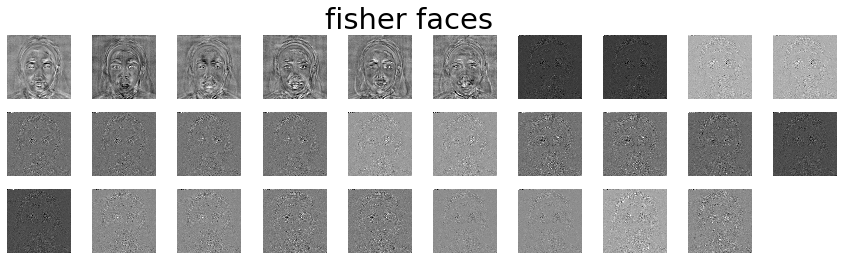

In [178]:
fig = plt.figure(figsize=(15,4))
for i in range(29):
    plt.subplot(3,10,i+1)
    plt.imshow(W.real[i].reshape(64, 64) , cmap='gray')
    plt.axis('off')
plt.suptitle('fisher faces', size = 29)

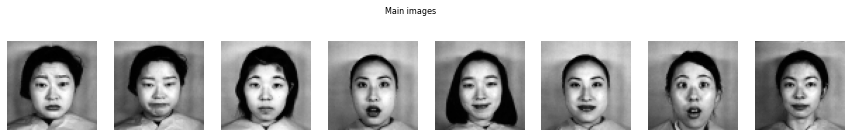

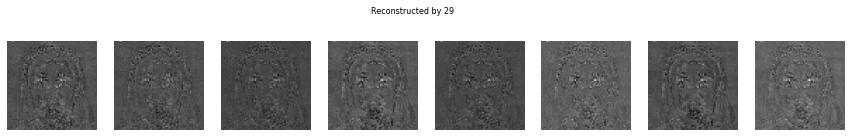

In [247]:
plot_recontruct(X_reconstruct, X, 29) 

In [248]:
mse_k_29 = MSE_element_wise(X, X_reconstruct)
mse_k_29

16177.170977989408

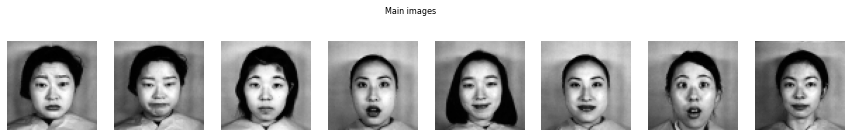

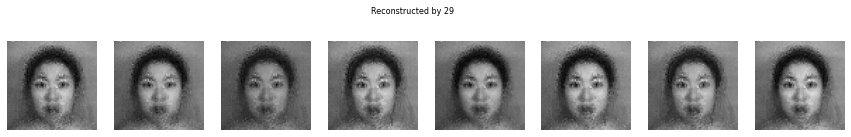

In [249]:
# Reconstruct with Adding mean face
X_reconstruct_addMean = lda.reconsturct(X_projected, add_mean=True)
plot_recontruct(X_reconstruct_addMean, X, 29) 

In [250]:
mse_k_29_addMean = MSE_element_wise(X, X_reconstruct_addMean)
mse_k_29_addMean

1512.2604370918211

Outlier with nonsense images adding

In [222]:

img_data_2, labels_2 = add_outlier(img_data, labels, outlier_percentage=10, outlier_method='nonsense-image')
# img_data_2, labels_2 = add_outlier(img_data, labels, 10, 'label-changing')
# img_data_2, labels_2 = add_outlier(img_data, labels, 10, 'hybrid')

print(labels_2)
print(len(img_data_2), img_data_2[0].shape)
# for i in range(len(img_data_2)):
#     print(i)
#     imshow(img_data_2[i], cmap=get_cmap("gray"), interpolation='nearest')
#     show()

[4, 2, 0, 6, 1, 1, 6, 0, 2, 3, 5, 6, 4, 5, 2, 0, 0, 5, 0, 4, 1, 4, 6, 3, 0, 4, 0, 6, 2, 0, 4, 0, 4, 6, 0, 1, 4, 1, 0, 4, 3, 6, 2, 0, 2, 0, 5, 1, 4, 2, 2, 5, 3, 6, 0, 6, 5, 1, 2, 1, 2, 5, 3, 1, 5, 2, 3, 5, 3, 4, 1, 1, 6, 0, 6, 2, 4, 1, 2, 3, 2, 2, 6, 5, 0, 4, 1, 3, 1, 6, 0, 4, 4, 1, 3, 0, 4, 0, 3, 0, 6, 5, 4, 0, 1, 1, 0, 2, 3, 1, 5, 6, 5, 3, 4, 5, 4, 3, 3, 5, 4, 6, 3, 5, 5, 2, 3, 3, 2, 6, 3, 5, 4, 5, 1, 2, 4, 3, 6, 4, 1, 5, 0, 3, 6, 3, 6, 5, 5, 6, 6, 6, 1, 4, 5, 1, 2, 1, 2, 0, 5, 2, 2, 1, 6, 2, 3, 4, 5, 1, 1, 4, 3, 4, 1, 2, 2, 3, 3, 2, 0, 1, 5, 5, 3, 4, 4]
187 (64, 64)


In [183]:
flat_imgs_2 = flaten(img_data_2)
flat_imgs_2.shape

(187, 4096)

In [251]:
# K basis vectors    K = 6

X = flat_imgs_2
y = labels_2
print("Shape of X:", X.shape)

n_components = 6

lda = FLDA()
lda.fit(X, y, epsilon=0.00093153)
W = lda.get_n_components(n_components)
print("Shape of W:", W.shape)

X_projected = lda.project(X)
print("Shape of projected X:", X_projected.shape)

X_reconstruct = lda.reconsturct(X_projected)
print("Shape of reconstructed X:", X_reconstruct.shape)


Shape of X: (187, 4096)
Shape of W: (6, 4096)
Shape of projected X: (187, 6)
Shape of reconstructed X: (187, 4096)


In [216]:
np.linalg.matrix_rank(lda.sing_SW)

4096

In [217]:
# temp = lda.SW + 0.00093153* np.eye(lda.SW.shape[0],lda.SW.shape[1])
# np.linalg.matrix_rank(temp)

Text(0.5, 0.98, 'fisher faces')

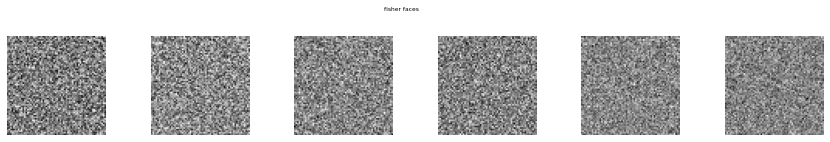

In [218]:
fig = plt.figure(figsize=(15,4))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(W.real[i].reshape(64, 64) , cmap='gray')
    plt.axis('off')
plt.suptitle('fisher faces', size = 6)

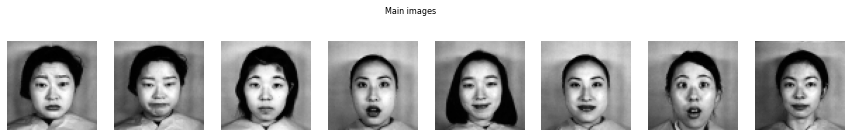

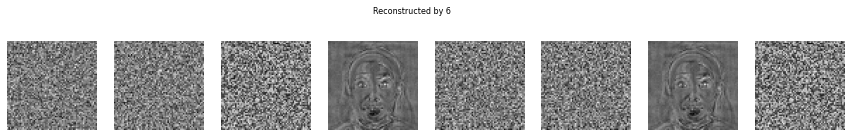

In [252]:
plot_recontruct(X_reconstruct, X, 6) 

In [254]:
mse_k_6_outlier = MSE_element_wise(X, X_reconstruct)
mse_k_6_outlier

14672.728421828733

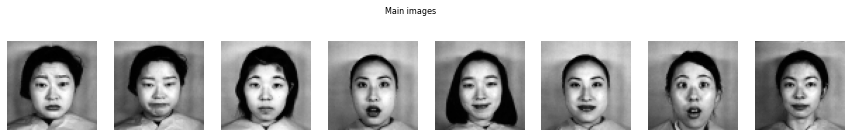

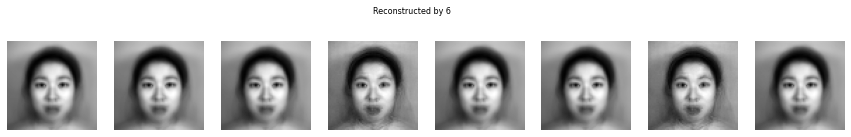

In [255]:
# Reconstruct with Adding mean face
X_reconstruct_addMean = lda.reconsturct(X_projected, add_mean=True)
plot_recontruct(X_reconstruct_addMean, X, 6) 

In [256]:
mse_k_6_outlier_addMean = MSE_element_wise(X, X_reconstruct_addMean)
mse_k_6_outlier_addMean

2465.147136423643

optimum k:  1


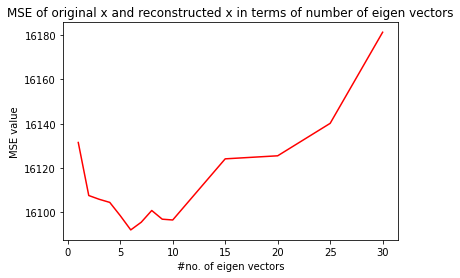

In [258]:

def find_mse_arr(X, y):
  # find mse for diffrent k (number of eigen vectors) and plot the result
  found_optimum_k = False
  optimum_k = 1
  min_error = math.inf
  epsilon = 1e-5
  mse_arr = []
  k_arr = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]

  lda = FLDA()
  lda.fit(X, y)

  for k in k_arr:
    # print("calculating k=", k, ".....")
    W = lda.get_n_components(k)
    X_projected = lda.project(X)
    X_reconstruct = lda.reconsturct(X_projected)

    tmp_mse = MSE_element_wise(X, X_reconstruct)
    mse_arr.append(tmp_mse)

    if tmp_mse < epsilon and found_optimum_k==False:
      optimum_k = k
      min_error = tmp_mse
      found_optimum_k = True
  
  return mse_arr, k_arr, optimum_k

def plot_mse_arr(mse_arr, num_of_eigen_vectors_arr):
  # plotting
  plt.title("MSE of original x and reconstructed x in terms of number of eigen vectors")
  plt.xlabel("#no. of eigen vectors")
  plt.ylabel("MSE value")
  plt.plot(num_of_eigen_vectors_arr, mse_arr, color ="red")
  plt.show()

X = flat_imgs
y = labels
mse_arr, k_arr, _ = find_mse_arr(X, y)
plot_mse_arr(mse_arr, k_arr)